In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# notebook will reload external python modules
%load_ext autoreload
%autoreload 2

In [2]:
# import data
data_raw = pd.read_csv('./data/iris.data', header=None)
# only 2 classes are needed
data = np.array(data_raw)[:100]

all_num = data.shape[0]
val_num = all_num // 5
test_num = all_num // 5
train_num = all_num - val_num - test_num

print('all_num:{}, val_num:{}, test_num:{}, train_num:{}'.format(all_num, val_num, test_num, train_num))

all_num:100, val_num:20, test_num:20, train_num:60


In [3]:
# change the label into {-1, 1}
for idx in range(all_num):
    item = data[idx][4]
    if item == 'Iris-setosa':
        data[idx][4] = 1
    elif item == 'Iris-versicolor':
        data[idx][4] = -1
    # elif item == 'Iris-virginica':
    #     data[idx][4] = 2
    else:
        raise ValueError("data_label unmatched")

# shuffle the set
data_shuffled = data.copy().astype(float)
np.random.shuffle(data_shuffled)

# mask
train_mask = range(train_num)
val_mask = range(train_num,train_num+val_num)
test_mask = range(train_num + val_num, train_num + val_num + test_num)
# devide set into 3 parts (train, val, test)
x_train = data_shuffled[train_mask, 0:4]
y_train = data_shuffled[train_mask, 4]
x_val = data_shuffled[val_mask, 0:4]
y_val = data_shuffled[val_mask, 4]
x_test = data_shuffled[test_mask, 0:4]
y_test = data_shuffled[test_mask, 4]


In [4]:
# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import torch.nn.functional as F

In [5]:
USE_GPU = False

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [6]:
# define my dataset class
class MyNormalize(object):
    """ 
    Normalize a tensor
    Assume that tensor less than 2 dimensions is label
    """
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, data):
        if len(data.shape) > 1:
            data = (data - self.mean) / (std + 1e-7)
        return data

class MyToTensor(object):
    """
    Convert a numpy array to a tensor
    """
    def __init__(self):
        pass
    def __call__(self, data):
        if not torch.is_tensor(data):
            data = torch.tensor(data)
            data = data.to(device=device, dtype=dtype)
        return data

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
    def __getitem__(self, index):
        if self.transform:
            return self.transform(self.x[index]), self.transform(self.y[index])
        else:
            return self.x[index], self.y[index]
    def __len__(self):
        return len(self.x)
# preprocess the data
mean = np.mean(x_train[:4], axis=0, keepdims=True)
std = np.std(y_train[:4], axis=0, keepdims=True)
transform = T.Compose([
                MyToTensor(),
                MyNormalize(mean, std)
            ])
print('mean:{}, std:{}'.format(mean, std))
data_train = MyDataset(x_train, y_train, transform=transform)
data_val = MyDataset(x_val, y_val, transform=transform)
data_test = MyDataset(x_test, y_test, transform=transform)

loader_train = DataLoader(data_train, batch_size=16, shuffle=False)
loader_val = DataLoader(data_val, batch_size=16, shuffle=False)
loader_test = DataLoader(data_test, batch_size=16, shuffle=False)

mean:[[5.675 3.1   3.4   1.05 ]], std:[0.8660254]


In [7]:
# Peceptron
class Peceptron(nn.Module):
    def __init__(self, in_features, bias=True):
        super().__init__()
        self.fc = nn.Linear(in_features, 1, bias=True)
        nn.init.kaiming_normal_(self.fc.weight)
    def forward(self, x):
        scores = None
        scores = self.fc(x)
        return scores

In [43]:
def check_accuracy(model, loader, need_print=True):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            scores = model(x.float()).view(1,-1)
            pred = scores * y
            pred = np.array([1 if x > 0 else 0 for x in pred])
            num_correct += pred.sum().item()
            num_samples += x.shape[0]
        acc = float(num_correct) / num_samples
    if need_print:
        print('Got {} / {} correct {:.2%}'.format(num_correct, num_samples, acc))
    return acc

def easy_train_model(model, optimizer, scheduler=None, epochs=1):
    # start iteration
    model = model.to(device=device)
    loss_history = []
    acc_history = []
    for e in range(epochs):
        for iters, (x, y) in enumerate(loader_train):
            model.train()   # put the model to training mode
            # forward
            scores = model(x.float()).view(1,-1)
            loss = torch.mean(torch.clamp(-scores*y, min=0))
            # backward + optimize
            optimizer.zero_grad() # zero the parameter gradients
            loss.backward() # backward pass
            optimizer.step() # update the parameters
            # something useful for tuning hyperparameter
            model.eval()
            with torch.no_grad():
                loss_history.append(loss) # store the loss
                pred = scores * y
                pred = np.array([1 if x > 0 else 0 for x in pred])
                # pred[pred>0] = 1
                # pred[pred<=0] = 0
                num_correct = pred.sum().item()
                acc_train = float(num_correct) / x.shape[0]
                acc_history.append(acc_train)
    # print & draw
    plt.subplot(2,1,1)
    plt.title('The history of the loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.plot(range(1,len(loss_history)+1), loss_history, 'o')

    plt.subplot(2,1,2)
    plt.title('The history of the training acc')
    plt.xlabel('Iteration')
    plt.ylabel('Acc')
    plt.plot(range(1,len(acc_history)+1), acc_history)

    plt.tight_layout(pad=3.0)
    plt.show()

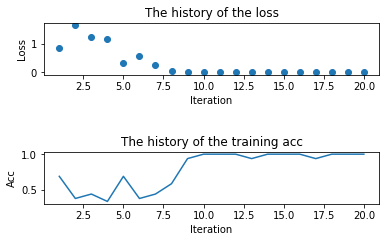

Got 20.0 / 20 correct 100.00%


1.0

In [47]:
in_features = 4
model = Peceptron(in_features)

optimizer = optim.SGD(model.parameters(), lr=0.02)
easy_train_model(model, optimizer, epochs=5)
check_accuracy(model, loader_val)

In [48]:
check_accuracy(model, loader_test)

Got 20.0 / 20 correct 100.00%


1.0